# **Custom Dataset**

In [ ]:
!pip install torch torchvision pycocotools matplotlib opencv-python

In [ ]:
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
from pycocotools.coco import COCO
from torch import nn, optim
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import os


In [ ]:
# Define classes of interest
classes_of_interest = ['bottle', 'cup', 'book', 'cell phone']
class_ids = []

In [ ]:
# Download COCO dataset (2017 Val set for demonstration)
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip val2017.zip
!unzip annotations_trainval2017.zip


Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/000000197004.jpg  
 extracting: val2017/00000052

In [ ]:
# Load COCO annotations
coco = COCO('annotations/instances_val2017.json')

loading annotations into memory...
Done (t=1.27s)
creating index...
index created!


In [ ]:
# Map class names to COCO class IDs
for cls in classes_of_interest:
    for cat in coco.dataset['categories']:
        if cat['name'] == cls:
            class_ids.append(cat['id'])
            break

print(f"Class IDs for {classes_of_interest}: {class_ids}")

Class IDs for ['bottle', 'cup', 'book', 'cell phone']: [44, 47, 84, 77]


In [ ]:
# Function to filter dataset for relevant classes
def filter_coco_dataset(coco, class_ids):
    image_ids = set()
    for cls_id in class_ids:
        img_ids = coco.getImgIds(catIds=cls_id)
        image_ids.update(img_ids)
    return list(image_ids)

image_ids = filter_coco_dataset(coco, class_ids)
print(f"Number of images with relevant classes: {len(image_ids)}")

Number of images with relevant classes: 948


In [ ]:
# Custom dataset class
class CustomCocoDataset(Dataset):
    def __init__(self, coco, img_ids, class_ids, transform=None):
        self.coco = coco
        self.img_ids = img_ids
        self.class_ids = class_ids
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join("val2017", img_info['file_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.class_ids)
        anns = self.coco.loadAnns(ann_ids)
        label = torch.tensor([self.class_ids.index(ann['category_id']) for ann in anns if ann['category_id'] in self.class_ids])
        label = label[0] if len(label) > 0 else torch.tensor(0)

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Dataset and DataLoader
dataset = CustomCocoDataset(coco, image_ids, class_ids, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Load and modify ResNet model
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_ids))
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()

<ipython-input-13-7f7d81d9e1a9>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# Training loop
# epochs = 20
# for epoch in range(epochs):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0

#     for inputs, labels in dataloader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()

#         with autocast():
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)

#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)

#     train_loss = running_loss / len(dataloader)
#     accuracy = (correct / total) * 100
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%")


# Lists to store training metrics
train_losses = []
train_accuracies = []

epochs = 20  # Ensure this is defined before plotting

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Store loss and accuracy for graph
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = (correct / total) * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")



<ipython-input-14-d54736a93e6e>:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/20, Loss: 1.2401, Accuracy: 43.57%
Epoch 2/20, Loss: 0.8964, Accuracy: 63.08%
Epoch 3/20, Loss: 0.6231, Accuracy: 77.22%
Epoch 4/20, Loss: 0.4414, Accuracy: 85.55%
Epoch 5/20, Loss: 0.3207, Accuracy: 87.97%
Epoch 6/20, Loss: 0.2833, Accuracy: 91.98%
Epoch 7/20, Loss: 0.2505, Accuracy: 91.88%
Epoch 8/20, Loss: 0.1382, Accuracy: 95.68%
Epoch 9/20, Loss: 0.1618, Accuracy: 94.41%
Epoch 10/20, Loss: 0.1992, Accuracy: 92.72%
Epoch 11/20, Loss: 0.1755, Accuracy: 93.35%
Epoch 12/20, Loss: 0.1542, Accuracy: 94.41%
Epoch 13/20, Loss: 0.1526, Accuracy: 94.41%
Epoch 14/20, Loss: 0.1203, Accuracy: 96.41%
Epoch 15/20, Loss: 0.1558, Accuracy: 95.78%
Epoch 16/20, Loss: 0.1552, Accuracy: 94.94%
Epoch 17/20, Loss: 0.1258, Accuracy: 96.73%
Epoch 18/20, Loss: 0.1445, Accuracy: 95.78%
Epoch 19/20, Loss: 0.1585, Accuracy: 94.83%
Epoch 20/20, Loss: 0.1435, Accuracy: 95.36%


In [ ]:
# Save model
torch.save(model.state_dict(), "fine_tuned_resnet.pth")

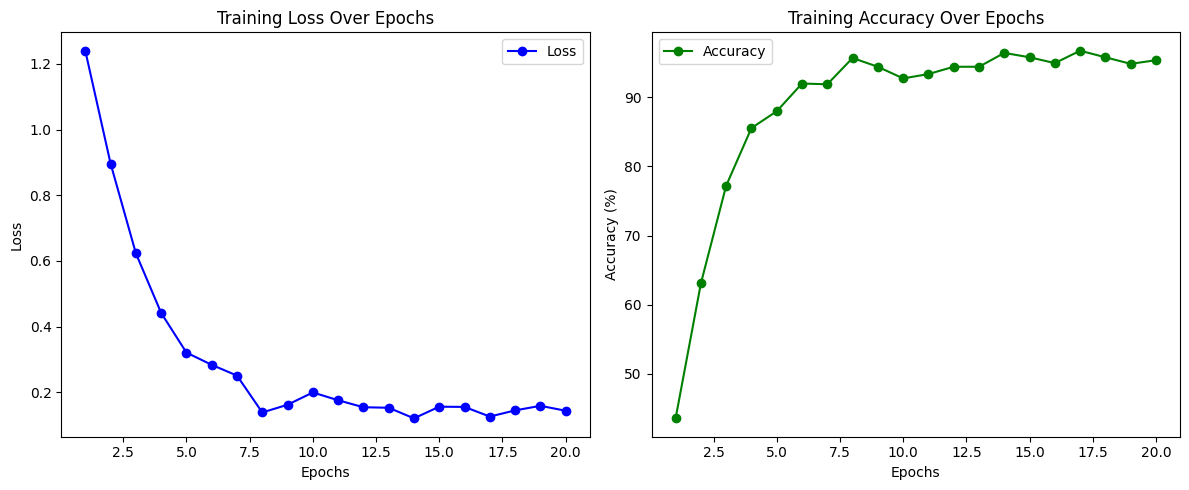

In [ ]:
import matplotlib.pyplot as plt

# Check if lists are populated
if not train_losses or not train_accuracies:
    print("Error: Training losses and accuracies are empty. Ensure training loop stores values.")

else:
    plt.figure(figsize=(12, 5))

    # Loss graph
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, marker='o', linestyle='-', color='b', label="Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()

    # Accuracy graph
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, marker='o', linestyle='-', color='g', label="Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Function to test the model and store test accuracy
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    test_accuracies = []  # Store accuracy per batch

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader, start=1):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Store batch-wise accuracy
            batch_accuracy = (correct / total) * 100
            test_accuracies.append(batch_accuracy)

            print(f"Batch {batch_idx}: Accuracy {batch_accuracy:.2f}%")

    final_accuracy = (correct / total) * 100
    print(f"\nFinal Test Accuracy: {final_accuracy:.2f}%")

    return test_accuracies  # Ensure this gets returned

# Run testing and store accuracy
test_accuracies = test_model(model, dataloader)  # Ensure this runs before plotting


Batch 1: Accuracy 100.00%
Batch 2: Accuracy 100.00%
Batch 3: Accuracy 100.00%
Batch 4: Accuracy 100.00%
Batch 5: Accuracy 100.00%
Batch 6: Accuracy 100.00%
Batch 7: Accuracy 100.00%
Batch 8: Accuracy 99.22%
Batch 9: Accuracy 99.31%
Batch 10: Accuracy 99.38%
Batch 11: Accuracy 99.43%
Batch 12: Accuracy 99.48%
Batch 13: Accuracy 99.52%
Batch 14: Accuracy 99.11%
Batch 15: Accuracy 99.17%
Batch 16: Accuracy 99.22%
Batch 17: Accuracy 99.26%
Batch 18: Accuracy 99.31%
Batch 19: Accuracy 99.34%
Batch 20: Accuracy 99.38%
Batch 21: Accuracy 99.11%
Batch 22: Accuracy 99.15%
Batch 23: Accuracy 98.91%
Batch 24: Accuracy 98.96%
Batch 25: Accuracy 99.00%
Batch 26: Accuracy 98.80%
Batch 27: Accuracy 98.84%
Batch 28: Accuracy 98.88%
Batch 29: Accuracy 98.92%
Batch 30: Accuracy 98.96%
Batch 31: Accuracy 98.79%
Batch 32: Accuracy 98.83%
Batch 33: Accuracy 98.86%
Batch 34: Accuracy 98.90%
Batch 35: Accuracy 98.93%
Batch 36: Accuracy 98.96%
Batch 37: Accuracy 98.99%
Batch 38: Accuracy 99.01%
Batch 39: Accu

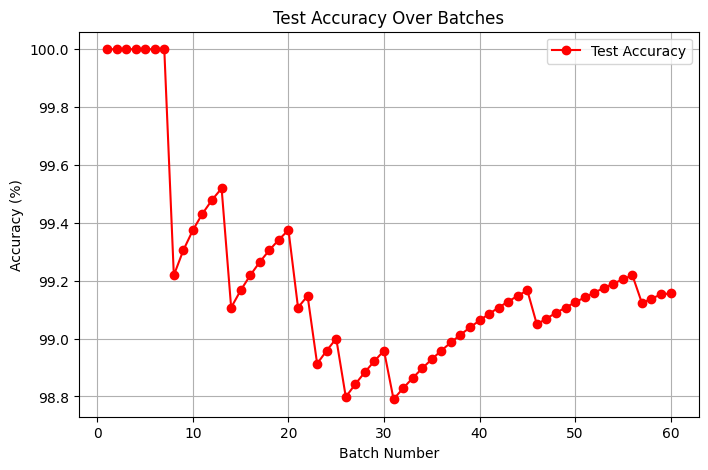

In [ ]:
import matplotlib.pyplot as plt

# Ensure test_accuracies exists before plotting
if 'test_accuracies' not in globals() or not test_accuracies:
    print("Error: No test accuracy data. Ensure test_model() runs first.")
else:
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-', color='r', label="Test Accuracy")
    plt.xlabel("Batch Number")
    plt.ylabel("Accuracy (%)")
    plt.title("Test Accuracy Over Batches")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
from google.colab import files

# Download the saved model to your local PC
files.download('fine_tuned_resnet.pth')  # Replace with your model file name if different


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>